sample_indices ['/data/ij/edge/LDC/edge_interface_synthesis/big_apple.jpg', None]
mean_bgr: [103.939, 116.779, 123.68]
Restoring weights from: checkpoints/BRIND/11/11_model.pth
************ image_path /data/ij/edge/LDC/edge_interface_synthesis/big_apple.jpg
actual size: (256, 256, 3), target size: (512, 512)
['big_apple.png']: torch.Size([1, 3, 512, 512])
fuse shape (256, 256)
main fues [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]] (256, 256)
-------------------------------------------------------
origin fuse (256, 256) uint8 <class 'numpy.ndarray'>
 fuse (256, 256) uint8 <class 'numpy.ndarray'>
polygons [array([54, 86, 55, 85, 56, 86, 57, 86, 59, 88, 59, 89, 61, 91, 61, 92, 62,
       93, 62, 94, 63, 95, 63, 96, 62, 97, 60, 95, 60, 94, 57, 91, 57, 90,
       54, 87], dtype=int32), array([53, 85, 54, 84, 55, 85, 54, 86], dtype=int32), array([

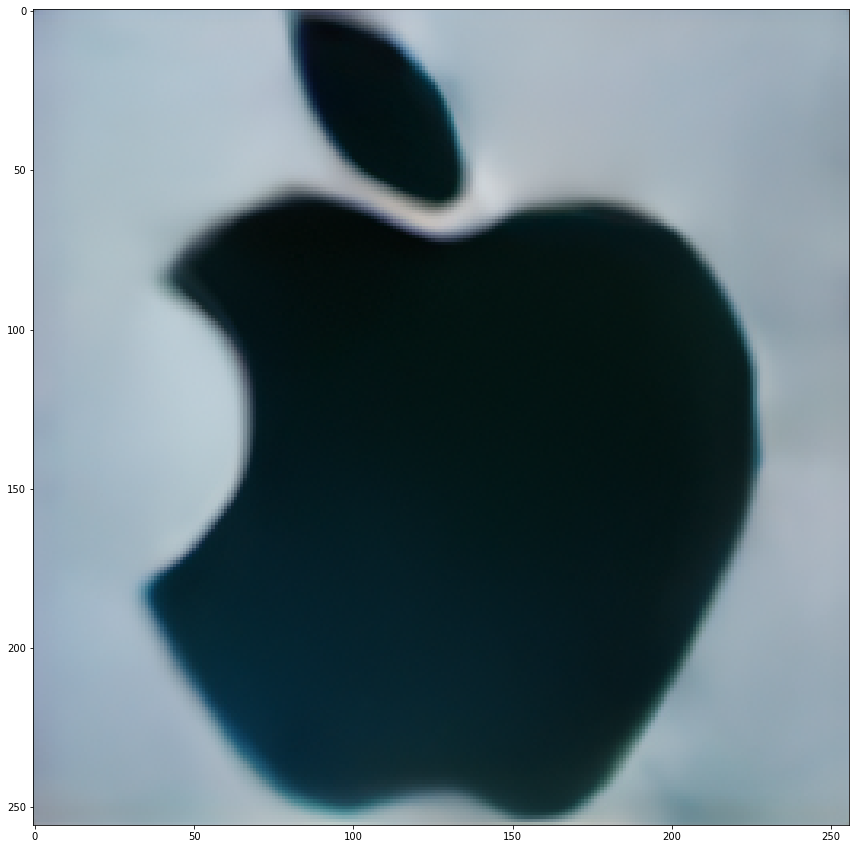

polygon_list [[54, 86, 55, 85, 56, 86, 57, 86, 59, 88, 59, 89, 61, 91, 61, 92, 62, 93, 62, 94, 63, 95, 63, 96, 62, 97, 60, 95, 60, 94, 57, 91, 57, 90, 54, 87], [53, 85, 54, 84, 55, 85, 54, 86], [82, 58, 83, 57, 92, 57, 93, 58, 95, 58, 96, 59, 98, 59, 99, 60, 101, 60, 102, 61, 104, 61, 105, 62, 106, 62, 107, 63, 108, 63, 109, 64, 111, 64, 112, 65, 113, 65, 114, 66, 115, 66, 116, 67, 118, 67, 119, 68, 120, 68, 121, 69, 123, 69, 124, 70, 135, 70, 136, 69, 138, 69, 139, 68, 140, 68, 141, 67, 142, 67, 143, 66, 144, 66, 145, 65, 146, 65, 148, 63, 149, 63, 150, 62, 152, 62, 153, 61, 155, 61, 156, 60, 162, 60, 163, 59, 168, 59, 169, 58, 177, 58, 178, 59, 182, 59, 183, 60, 186, 60, 187, 61, 188, 61, 189, 62, 191, 62, 192, 63, 193, 63, 194, 64, 196, 64, 197, 65, 198, 65, 200, 67, 201, 67, 211, 77, 211, 78, 215, 82, 215, 83, 217, 85, 217, 86, 218, 87, 218, 88, 219, 89, 219, 90, 221, 92, 221, 93, 222, 94, 222, 96, 223, 97, 223, 98, 224, 99, 224, 100, 225, 101, 225, 103, 226, 104, 226, 106, 227, 10

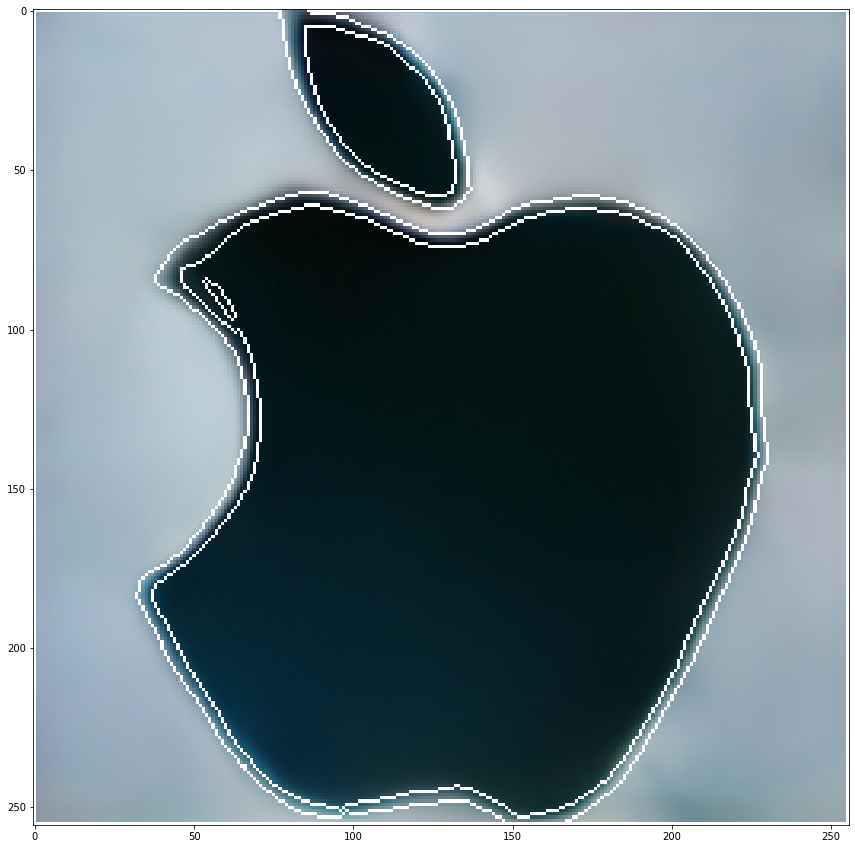

In [1]:

from __future__ import print_function

import argparse
import os
import time, platform

import cv2
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from thop import profile

from dataset import DATASET_NAMES, BipedDataset, dataset_info
from torch.utils.data import Dataset

from modelB4 import LDC


IS_LINUX = True if platform.system()=="Linux" else False


class TestDataset(Dataset):
    def __init__(self,
                 data_root,
                 test_data,
                 mean_bgr,
                 img_height,
                 img_width,
                 test_list=None,
                 arg=None
                 ):


        self.data_root = data_root
        self.test_data = test_data
        self.test_list = test_list

        self.mean_bgr = mean_bgr
        self.img_height = img_height
        self.img_width = img_width
        self.data_index = self._build_index()

        print(f"mean_bgr: {self.mean_bgr}")

    def _build_index(self):
        sample_indices = []
        if self.test_data == "CLASSIC":
            # for single image testing
#             images_path = os.listdir(self.data_root)
            images_path = self.data_root
            labels_path = None
            sample_indices = [images_path, labels_path]
            print('sample_indices',sample_indices)
       
        return sample_indices

    def __len__(self):
        return 1 if self.test_data.upper() == 'CLASSIC' else len(self.data_index)

    def __getitem__(self, idx):
        # get data sample
        # image_path, label_path = self.data_index[idx]
        if self.data_index[1] is None:
            image_path = self.data_index[0] if len(self.data_index[0]) > 1 else self.data_index[0]
            print(f'************ image_path {image_path}')
        else:
            image_path = self.data_index[idx][0]
        label_path = None if self.test_data == "CLASSIC" else self.data_index[idx][1]
#         img_name = os.path.basename(image_path)
#         file_name = os.path.splitext(img_name)[0] + ".png"
        img_name = self.data_root.split('/')
        img_name = img_name[-1]
        file_name = os.path.splitext(img_name)[0] + ".png"
        


        gt_dir = None


        image = cv2.imread(self.data_root, cv2.IMREAD_COLOR)

        if not self.test_data == "CLASSIC":
            label = cv2.imread(os.path.join(
                gt_dir, label_path), cv2.IMREAD_COLOR)
        else:
            label = None
        
        im_shape = [image.shape[0], image.shape[1]]
        image, label = self.transform(img=image, gt=label)

        return dict(images=image, labels=label, file_names=file_name, image_shape=im_shape)

    def transform(self, img, gt):
        # gt[gt< 51] = 0 # test without gt discrimination
        if self.test_data == "CLASSIC":
            img_height = self.img_height
            img_width = self.img_width
            print(
                f"actual size: {img.shape}, target size: {(img_height, img_width,)}")
            # img = cv2.resize(img, (self.img_width, self.img_height))
            img = cv2.resize(img, (img_width, img_height))
            gt = None

        # Make images and labels at least 512 by 512
        elif img.shape[0] < 512 or img.shape[1] < 512:
            img = cv2.resize(img, (self.img_width, self.img_height))  # 512
            gt = cv2.resize(gt, (self.img_width, self.img_height))  # 512

        # Make sure images and labels are divisible by 2^4=16
        elif img.shape[0] % 16 != 0 or img.shape[1] % 16 != 0:
            img_width = ((img.shape[1] // 16) + 1) * 16
            img_height = ((img.shape[0] // 16) + 1) * 16
            img = cv2.resize(img, (img_width, img_height))
            gt = cv2.resize(gt, (img_width, img_height))
        else:
            img_width = self.img_width
            img_height = self.img_height
            img = cv2.resize(img, (img_width, img_height))
            gt = cv2.resize(gt, (img_width, img_height))
        # # For FPS
        # img = cv2.resize(img, (496,320))
        # if self.yita is not None:
        #     gt[gt >= self.yita] = 1
        img = np.array(img, dtype=np.float32)
        # if self.rgb:
        #     img = img[:, :, ::-1]  # RGB->BGR
        img -= self.mean_bgr
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img.copy()).float()

        if self.test_data == "CLASSIC":
            gt = np.zeros((img.shape[:2]))
            gt = torch.from_numpy(np.array([gt])).float()
        else:
            gt = np.array(gt, dtype=np.float32)
            if len(gt.shape) == 3:
                gt = gt[:, :, 0]
            gt /= 255.
            gt = torch.from_numpy(np.array([gt])).float()

        return img, gt

def image_normalization(img, img_min=0, img_max=255,
                        epsilon=1e-12):
    """This is a typical image normalization function
    where the minimum and maximum of the image is needed
    source: https://en.wikipedia.org/wiki/Normalization_(image_processing)

    :param img: an image could be gray scale or color
    :param img_min:  for default is 0
    :param img_max: for default is 255

    :return: a normalized image, if max is 255 the dtype is uint8
    """

    img = np.float32(img)
    # whenever an inconsistent image
    img = (img - np.min(img)) * (img_max - img_min) / \
        ((np.max(img) - np.min(img)) + epsilon) + img_min
    return img

def save_image_batch_to_disk(tensor, output_dir, file_names, img_shape=None,  is_inchannel=False):

    os.makedirs(output_dir, exist_ok=True)
    is_testing = True
   

    fuse_name = 'fused'
    av_name = 'avg'
    tensor2=None
    tmp_img2 = None

    output_dir_f = os.path.join(output_dir, fuse_name)
    output_dir_a = os.path.join(output_dir, av_name)
    os.makedirs(output_dir_f, exist_ok=True)
    os.makedirs(output_dir_a, exist_ok=True)

    # 255.0 * (1.0 - em_a)
    edge_maps = []
    for i in tensor:
        tmp = torch.sigmoid(i).cpu().detach().numpy()
        edge_maps.append(tmp)
    tensor = np.array(edge_maps)
    # print(f"tensor shape: {tensor.shape}")

    image_shape = [x.cpu().detach().numpy() for x in img_shape]
    # (H, W) -> (W, H)
    image_shape = [[y, x] for x, y in zip(image_shape[0], image_shape[1])]

    assert len(image_shape) == len(file_names)

    idx = 0
    for i_shape, file_name in zip(image_shape, file_names):
        tmp = tensor[:, idx, ...]
        tmp2 = tensor2[:, idx, ...] if tensor2 is not None else None
        # tmp = np.transpose(np.squeeze(tmp), [0, 1, 2])
        tmp = np.squeeze(tmp)
        tmp2 = np.squeeze(tmp2) if tensor2 is not None else None

        # Iterate our all 7 NN outputs for a particular image
        preds = []
        fuse_num = tmp.shape[0]-1
        for i in range(tmp.shape[0]):
            tmp_img = tmp[i]
            tmp_img = np.uint8(image_normalization(tmp_img))
            tmp_img = cv2.bitwise_not(tmp_img)
            # tmp_img[tmp_img < 0.0] = 0.0
            # tmp_img = 255.0 * (1.0 - tmp_img)
            if tmp2 is not None:
                tmp_img2 = tmp2[i]
                tmp_img2 = np.uint8(image_normalization(tmp_img2))
                tmp_img2 = cv2.bitwise_not(tmp_img2)

            # Resize prediction to match input image size
            if not tmp_img.shape[1] == i_shape[0] or not tmp_img.shape[0] == i_shape[1]:
                tmp_img = cv2.resize(tmp_img, (i_shape[0], i_shape[1]))
                tmp_img2 = cv2.resize(tmp_img2, (i_shape[0], i_shape[1])) if tmp2 is not None else None


            if tmp2 is not None:
                tmp_mask = np.logical_and(tmp_img>128,tmp_img2<128)
                tmp_img= np.where(tmp_mask, tmp_img2, tmp_img)
                preds.append(tmp_img)

            else:
                preds.append(tmp_img)

            if i == fuse_num:
                # print('fuse num',tmp.shape[0], fuse_num, i)
                fuse = tmp_img
                fuse = fuse.astype(np.uint8)
                if tmp_img2 is not None:
                    fuse2 = tmp_img2
                    fuse2 = fuse2.astype(np.uint8)
                    # fuse = fuse-fuse2
                    fuse_mask=np.logical_and(fuse>128,fuse2<128)
                    fuse = np.where(fuse_mask,fuse2, fuse)

                    # print(fuse.shape, fuse_mask.shape)

        # Get the mean prediction of all the 7 outputs
        average = np.array(preds, dtype=np.float32)
        average = np.uint8(np.mean(average, axis=0))
        output_file_name_f = os.path.join(output_dir_f, file_name)
        output_file_name_a = os.path.join(output_dir_a, file_name)
        
        
        fuse[fuse >= 150] = 255
        fuse[fuse < 200] = 0
        print('fuse shape', fuse.shape)
        
        
        cv2.imwrite(output_file_name_f, fuse)
        cv2.imwrite(output_file_name_a, average)

        idx += 1
        return fuse, average

def test(checkpoint_path, dataloader, model, device, output_dir):
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(
            f"Checkpoint filte note found: {checkpoint_path}")
    print(f"Restoring weights from: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path,
                                     map_location=device))

    model.eval()

    with torch.no_grad():
        for batch_id, sample_batched in enumerate(dataloader):
            images = sample_batched['images'].to(device)

            file_names = sample_batched['file_names']

            image_shape = sample_batched['image_shape']

            print(f"{file_names}: {images.shape}")

            end = time.perf_counter()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            preds = model(images)


            if device.type == 'cuda':
                torch.cuda.synchronize()

            fuse, average = save_image_batch_to_disk(preds,
                                     output_dir,
                                     file_names,
                                     image_shape)
            torch.cuda.empty_cache()
    return fuse, average





def main(img_path):
    """Main function."""



    checkpoint_path = 'checkpoints/BRIND/11/11_model.pth'


    device = torch.device('cpu' if torch.cuda.device_count() == 0
                          else 'cuda')

    # Instantiate model and move it to the computingf device
    model = LDC().to(device)



    TEST_DATA = 'CLASSIC'

    test_inf = dataset_info(TEST_DATA, is_linux=IS_LINUX)

    # test_inf {'img_height': 512, 'img_width': 512, 'test_list': None, 'train_list': None, 'data_dir': 'data', 'yita': 0.5}
    
    test_dir = test_inf['data_dir']
    input_val_dir = img_path
    test_list = test_inf['test_list']
    test_img_width = test_inf['img_width']
    test_img_height = test_inf['img_height']
    mean_pixel_values = [103.939,116.779,123.68,137.86]    
    workers = 8
    
    dataset_val = TestDataset(input_val_dir,
                              test_data=TEST_DATA,
                              img_width=test_img_width,
                              img_height=test_img_height,
                              mean_bgr=mean_pixel_values[0:3] if len(
                                  mean_pixel_values) == 4 else mean_pixel_values,
                              test_list=test_list
                              )
    dataloader_val = DataLoader(dataset_val,
                                batch_size=1,
                                shuffle=False,
                                num_workers=workers)


    output_dir = 'result/BRIND2CLASSIC'

    fuse, average = test(checkpoint_path, dataloader_val, model, device, output_dir)
    print('main fues', fuse, fuse.shape)


    print('-------------------------------------------------------')
    
    return fuse, average




if __name__ == '__main__':
    from imantics import Polygons, Mask
    import glob
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt


    img_path = f'/data/ij/edge/LDC/edge_interface_synthesis/big_apple.jpg'

    fuse, average = main(img_path)
    print('origin fuse', fuse.shape, fuse.dtype, type(fuse))

    kernel = np.ones((5, 5), np.uint8)    
    img_dilation = cv2.dilate(fuse, kernel, iterations=1)
    print(' fuse', fuse.shape, fuse.dtype, type(fuse))
    

#     img_edge[img_edge == 0] = 1
#     img_edge[img_edge == 255] = 0
#     img_edge[img_edge == 1] = 255
    polygons = Mask(fuse).polygons()
    print('polygons', polygons)



    cnt = 0
    polygon_list = []
    for seg in polygons.segmentation: 
        if len(seg) > 3:
            cnt+=1

            polygon_list.append(seg)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)
    plt.imshow(image)
    plt.show()

    print('polygon_list', polygon_list)
    for polygon in polygon_list:
        print('polygon', polygon)

        points = np.array(polygon)
        points = points.reshape(int(len(polygon)/2),2)
        pts = np.array(points,np.int32)
        pts = pts.reshape((-1, 1, 2))

#             color_np = np.asarray(np.random.choice(range(256), size=3), dtype=np.uint8)
#             color_fill = (color_np[0].item(),color_np[1].item(),color_np[2].item())
#             image = cv2.fillPoly(image, pts=[pts], color=color_fill)
#             color_np = np.asarray(np.random.choice(range(256), size=3), dtype=np.uint8)
        color_np = np.asarray((255,255,255), dtype=np.uint8)
        color_fill = (color_np[0].item(),color_np[1].item(),color_np[2].item())


        isClosed = True
        color = (255, 0, 0)
        thickness = 1
        line_image = cv2.polylines(image, [pts], isClosed, color_fill, thickness)
#         cv2.imwrite('/data/ij/edge/LDC/test.png',line_image)



    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)
    plt.imshow(line_image)
    plt.show()


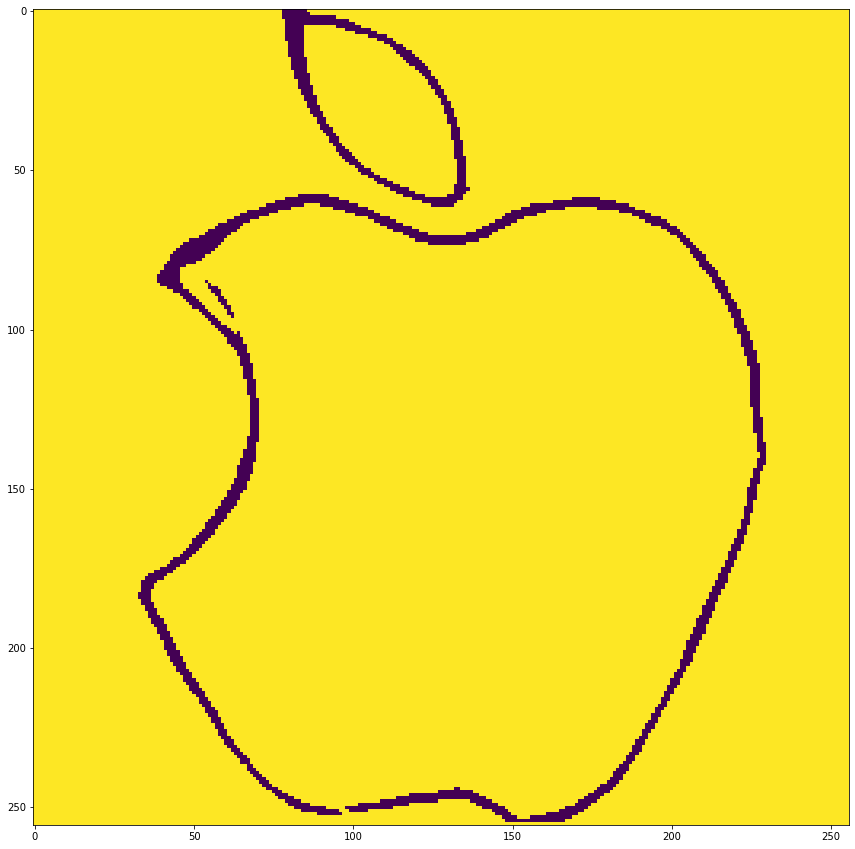

In [2]:
import pickle
save_json2 = {'mask':fuse}
with open(f'./mask.pickle', 'wb') as f:
    pickle.dump(save_json2, f, pickle.HIGHEST_PROTOCOL)

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.imshow(fuse)
plt.show()

In [3]:
mask = fuse


In [4]:
import numpy as np
from PIL import Image, ImageDraw
from shapely.geometry import Polygon, Point

print(len(polygon_list))

for idx, a in enumerate(polygon_list):
    print(f'idx : {idx}')
    if idx > 2 :
        break
    poly_points = [(a[i], a[i+1]) for i in range(0, len(a), 2)]
    print(f'poly_points : {poly_points}')
    polygon = Polygon(poly_points)
    print(f'polygon : {polygon}')
#     break
    height, width = mask.shape
    for y in range(height):
        for x in range(width):
            if polygon.contains(Point(x, y)):
                pass
                print(x, y,mask[y, x])
                mask[y, x] = 0
                


5
idx : 0
poly_points : [(54, 86), (55, 85), (56, 86), (57, 86), (59, 88), (59, 89), (61, 91), (61, 92), (62, 93), (62, 94), (63, 95), (63, 96), (62, 97), (60, 95), (60, 94), (57, 91), (57, 90), (54, 87)]
polygon : POLYGON ((54 86, 55 85, 56 86, 57 86, 59 88, 59 89, 61 91, 61 92, 62 93, 62 94, 63 95, 63 96, 62 97, 60 95, 60 94, 57 91, 57 90, 54 87, 54 86))
55 86 0
55 87 0
56 87 0
57 87 0
56 88 0
57 88 0
58 88 0
57 89 0
58 89 0
58 90 0
59 90 0
58 91 0
59 91 0
60 91 0
59 92 0
60 92 0
60 93 0
61 93 0
61 94 0
61 95 0
62 95 0
62 96 0
idx : 1
poly_points : [(53, 85), (54, 84), (55, 85), (54, 86)]
polygon : POLYGON ((53 85, 54 84, 55 85, 54 86, 53 85))
54 85 0
idx : 2
poly_points : [(82, 58), (83, 57), (92, 57), (93, 58), (95, 58), (96, 59), (98, 59), (99, 60), (101, 60), (102, 61), (104, 61), (105, 62), (106, 62), (107, 63), (108, 63), (109, 64), (111, 64), (112, 65), (113, 65), (114, 66), (115, 66), (116, 67), (118, 67), (119, 68), (120, 68), (121, 69), (123, 69), (124, 70), (135, 70), (136

83 58 0
84 58 0
85 58 0
86 58 0
87 58 0
88 58 0
89 58 0
90 58 0
91 58 0
92 58 0
79 59 0
80 59 0
81 59 0
82 59 0
83 59 0
84 59 0
85 59 0
86 59 0
87 59 0
88 59 0
89 59 0
90 59 0
91 59 0
92 59 0
93 59 0
94 59 0
95 59 0
169 59 0
170 59 0
171 59 0
172 59 0
173 59 0
174 59 0
175 59 0
176 59 0
177 59 0
76 60 0
77 60 0
78 60 0
79 60 0
80 60 0
81 60 0
82 60 0
83 60 0
84 60 0
85 60 0
86 60 0
87 60 0
88 60 0
89 60 0
90 60 0
91 60 0
92 60 0
93 60 0
94 60 0
95 60 0
96 60 0
97 60 0
98 60 0
163 60 0
164 60 0
165 60 0
166 60 0
167 60 0
168 60 0
169 60 0
170 60 0
171 60 0
172 60 0
173 60 0
174 60 0
175 60 0
176 60 0
177 60 0
178 60 0
179 60 0
180 60 0
181 60 0
182 60 0
73 61 0
74 61 0
75 61 0
76 61 0
77 61 0
78 61 0
79 61 0
80 61 0
81 61 0
82 61 0
83 61 0
84 61 0
90 61 0
91 61 0
92 61 0
93 61 0
94 61 0
95 61 0
96 61 0
97 61 0
98 61 0
99 61 0
100 61 0
101 61 0
156 61 0
157 61 0
158 61 0
159 61 0
160 61 0
161 61 0
162 61 0
163 61 0
164 61 0
165 61 0
166 61 0
167 61 0
168 61 0
169 61 0
170 61 0
171 61 0
1

226 129 0
227 129 0
228 129 0
68 130 0
69 130 0
70 130 0
226 130 0
227 130 0
228 130 0
68 131 0
69 131 0
70 131 0
226 131 0
227 131 0
228 131 0
68 132 0
69 132 0
70 132 0
226 132 0
227 132 0
228 132 0
68 133 0
69 133 0
70 133 0
227 133 0
228 133 0
67 134 0
68 134 0
69 134 0
70 134 0
227 134 0
228 134 0
67 135 0
68 135 0
69 135 0
70 135 0
227 135 0
228 135 0
67 136 0
68 136 0
69 136 0
227 136 0
228 136 0
229 136 0
67 137 0
68 137 0
69 137 0
227 137 0
228 137 0
229 137 0
66 138 0
67 138 0
68 138 0
69 138 0
227 138 0
228 138 0
229 138 0
66 139 0
67 139 0
68 139 0
69 139 0
228 139 0
229 139 0
66 140 0
67 140 0
68 140 0
69 140 0
228 140 0
229 140 0
65 141 0
66 141 0
67 141 0
68 141 0
69 141 0
227 141 0
228 141 0
229 141 0
65 142 0
66 142 0
67 142 0
68 142 0
227 142 0
228 142 0
229 142 0
64 143 0
65 143 0
66 143 0
67 143 0
68 143 0
227 143 0
228 143 0
64 144 0
65 144 0
66 144 0
67 144 0
68 144 0
226 144 0
227 144 0
228 144 0
64 145 0
65 145 0
66 145 0
67 145 0
68 145 0
226 145 0
227 145 0
64

147 253 0
148 253 0
149 253 0
150 253 0
151 253 0
156 253 0
157 253 0
158 253 0
159 253 0
160 253 0
161 253 0
162 253 0
163 253 0
164 253 0
165 253 0
166 253 0
167 253 0
168 253 0
148 254 0
149 254 0
150 254 0
151 254 0
152 254 0
153 254 0
154 254 0
155 254 0
156 254 0
157 254 0
158 254 0
159 254 0
160 254 0
161 254 0
162 254 0
163 254 0
164 254 0
165 254 0
166 254 0
idx : 3


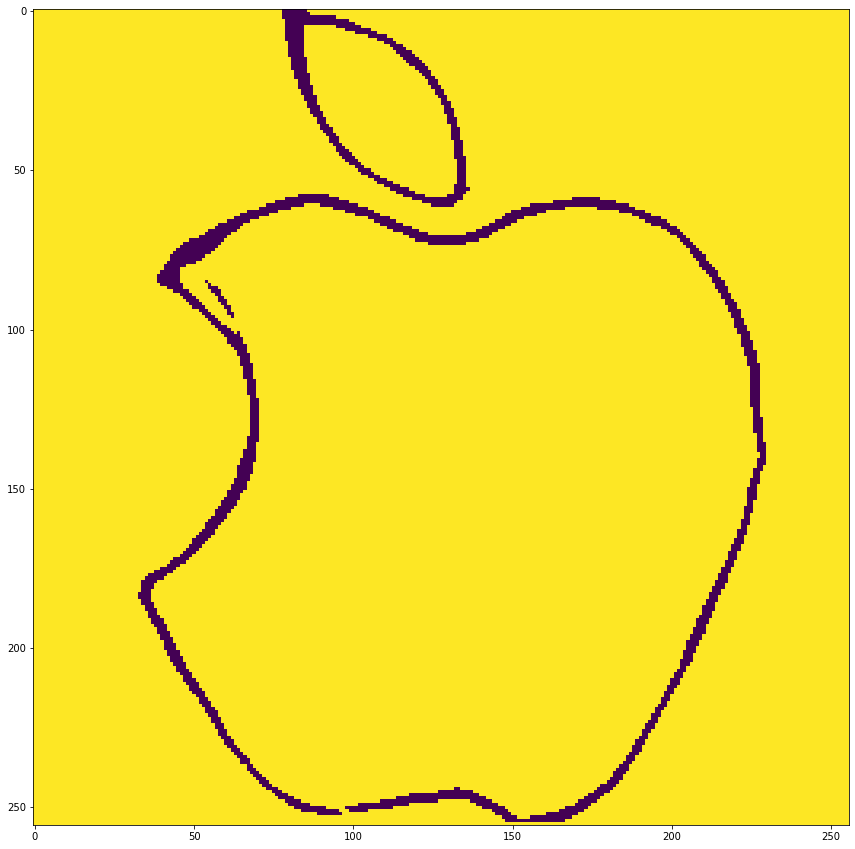

In [5]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.imshow(mask)
plt.show()

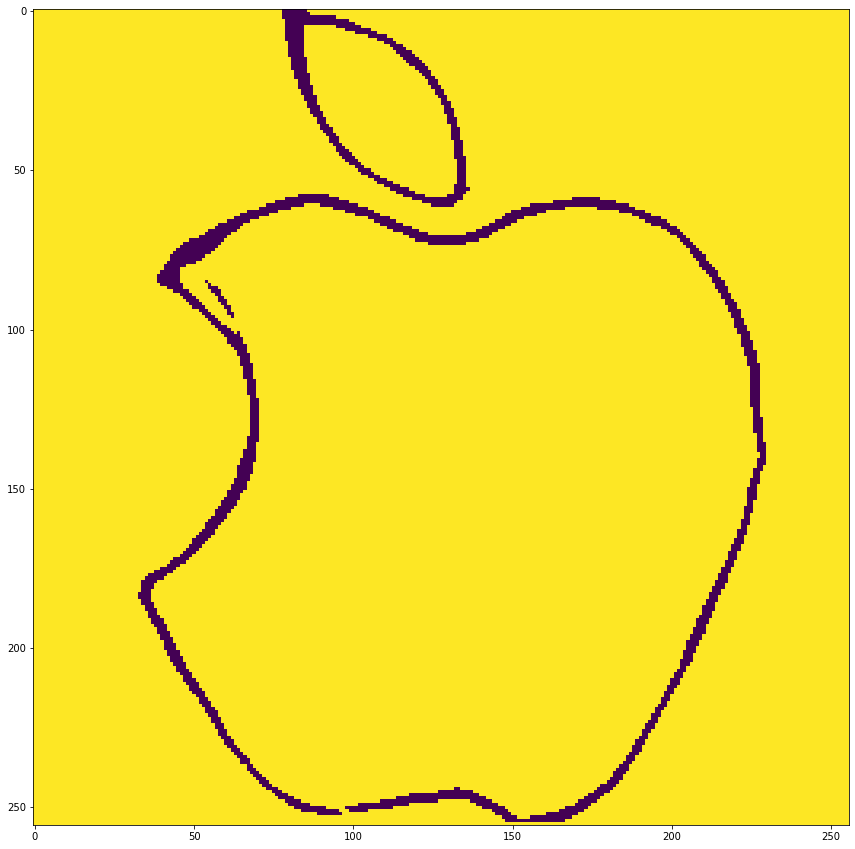

In [6]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.imshow(mask)
plt.show()

In [7]:
# b = cv2.getRotationMatrix2D((256/2,256/2), 45,1)
# # mask = cv2.warpAffine(mask, b,(256,256),borderMode = None,borderValue=255)
# mask = cv2.warpAffine(mask, b,(256,256), dst=None, flags=None, borderMode = None, borderValue = 255)
# print(mask)
# fuse[fuse >= 100] = 255
# fuse[fuse < 100] = 0
        
# f = plt.figure()
# f.set_figwidth(20)
# f.set_figheight(15)
# plt.imshow(mask)
# plt.show()


In [8]:
# mask = fuse
mask_inv = cv2.bitwise_not(mask)
mask_inv

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [9]:
img1 = cv2.imread(img_path)
img2 = cv2.imread("/data/ij/Mosaic_data_augmentation_YOLO/images_ori/1.jpg")

#--② ROI 선택을 위한 좌표 계산
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
x = (width2 - width1)//2
y = height2 - height1
w = x + width1
h = y + height1

In [10]:
roi = img2[y:h, x:w]
fg = cv2.bitwise_and(img1, img1, mask=mask_inv)
bg = cv2.bitwise_and(roi, roi, mask=mask)
img2[y:h, x:w] = fg + bg

In [11]:
# a = fg + bg
# a.shape
# b = cv2.getRotationMatrix2D((256/2,256/2), 45,1)
# ab = cv2.warpAffine(a, b,(256,256))

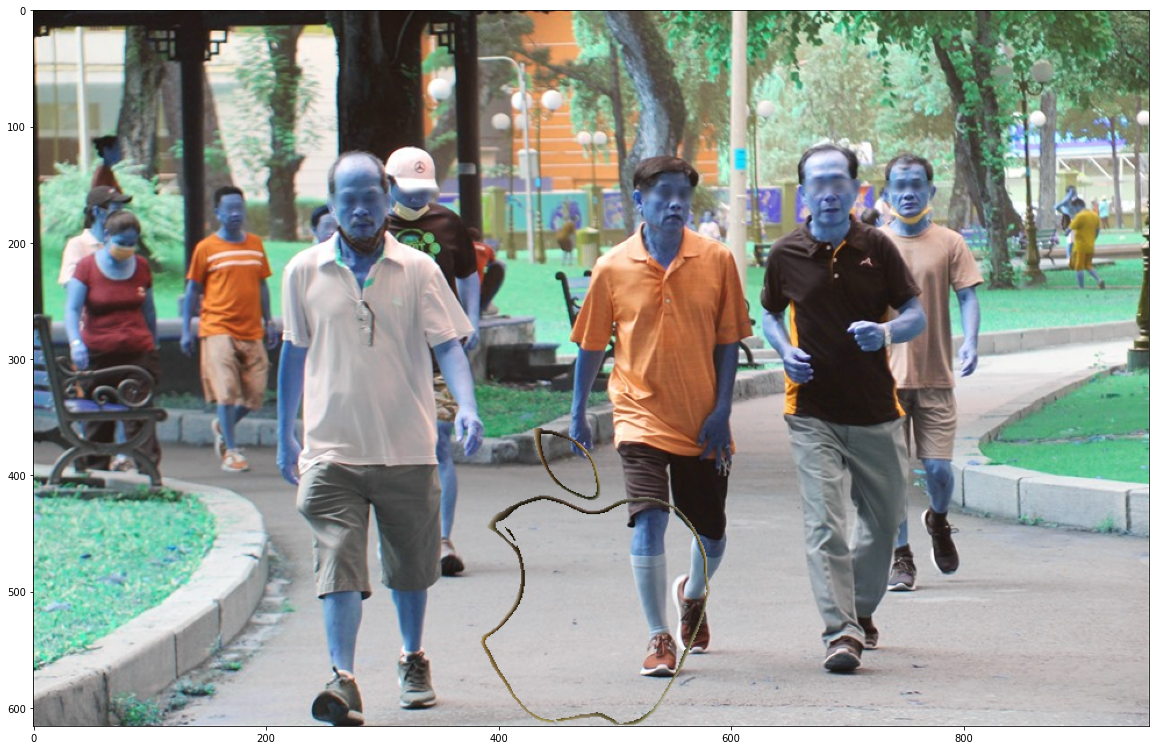

In [12]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)
plt.imshow(img2)
plt.show()

In [13]:
polygons = Mask(fuse).polygons()
print('polygons', polygons)



# cnt = 0
# polygon_list = []
# for seg in polygons.segmentation: 
#     if len(seg) > 3:
#         cnt+=1

#         polygon_list.append(seg)

polygons [array([54, 86, 55, 85, 56, 86, 57, 86, 59, 88, 59, 89, 61, 91, 61, 92, 62,
       93, 62, 94, 63, 95, 63, 96, 62, 97, 60, 95, 60, 94, 57, 91, 57, 90,
       54, 87], dtype=int32), array([53, 85, 54, 84, 55, 85, 54, 86], dtype=int32), array([82, 58, 83, ..., 59, 79, 58], dtype=int32), array([ 85,   5,  85,  14,  86,  15,  86,  19,  87,  20,  87,  23,  88,
        24,  88,  26,  89,  27,  89,  29,  90,  30,  90,  31,  91,  32,
        91,  33,  92,  34,  92,  35,  94,  37,  94,  38,  96,  40,  96,
        41, 104,  49, 105,  49, 107,  51, 108,  51, 109,  52, 110,  52,
       111,  53, 112,  53, 113,  54, 114,  54, 115,  55, 117,  55, 118,
        56, 119,  56, 120,  57, 122,  57, 123,  58, 129,  58, 130,  57,
       131,  57, 131,  55, 132,  54, 132,  47, 131,  46, 131,  41, 130,
        40, 130,  36, 129,  35, 129,  33, 128,  32, 128,  30, 127,  29,
       127,  28, 125,  26, 125,  25, 123,  23, 123,  22, 119,  18, 118,
        18, 111,  11, 110,  11, 109,  10, 108,  10, 107, 